In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from ephyspy.sweeps import EphysSweepSet, EphysSweep  # Custom class for handling sweeps
from ephyspy.features import *  # available spike, sweep and sweepset level features
from ephyspy.utils import get_feature
from ephyspy.plot import plot_sweepset_diagnostics, plot_spike_features


import jupyter_black
import time

jupyter_black.load()

In [2]:
def timeit(func, msg):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{msg}: {end-start:.4f} s")
        return result

    return wrapper

In [3]:
# load test data
test_data = np.load("tests/test_sweepset.npz", allow_pickle=True)
t_set, u_set, i_set = test_data["ts"], test_data["Uts"], test_data["Its"]
t_set *= 1e-3  # ms -> s
start, end = t_set[0, 0], t_set[0, -1]
dc_offset = -14.520833986604785

# each sweep should be a Tuple of numpy arrays (t, u, i) containing time (s),
# voltage (mV), and stimulus current (pA) arrays of shape (1, n_samples)
# dc_offset is the holding current (defaults to 0 if not supplied)

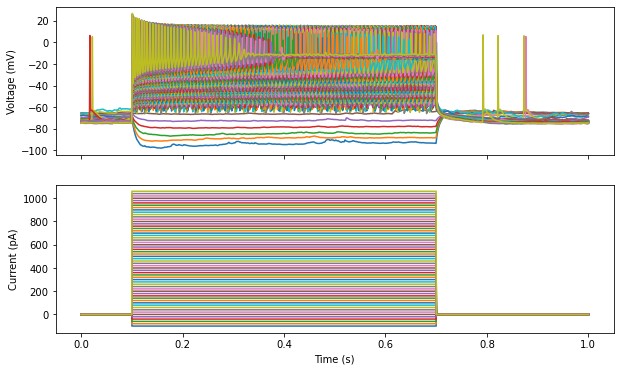

In [4]:
# what the raw data looks like
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(t_set.T, u_set.T)
axes[0].set_ylabel("Voltage (mV)")
axes[1].plot(t_set.T, i_set.T)
axes[1].set_ylabel("Current (pA)")
axes[1].set_xlabel("Time (s)")
plt.show()

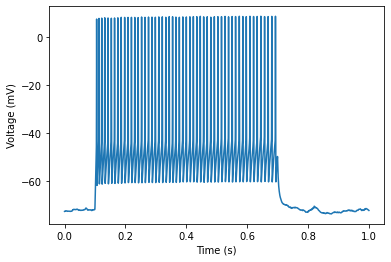

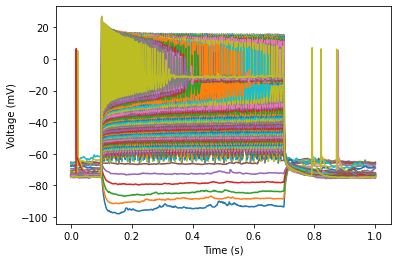

In [5]:
# The fundametal objects that this toolbox operates on a are `EphysSweep`s
# and `EphysSweepSet`s, which are wrapped versions of the AllenSDKs
# `EphysSweepExtractor` and `EphysSweepSetExtractor` classes to provide additional
# functionality and a more intuitive interface.

# These can be created from the above data as follows:
# create sweep
example_sweep = EphysSweep(
    t_set[13], u_set[13], i_set[13], filter=1, metadata={"dc_offset": dc_offset}
)

# the `.plot()` method enables quick visualization of the data
example_sweep.plot()


# create sweepset
example_sweepset = EphysSweepSet(
    t_set,
    u_set,
    i_set,
    filter=1,
    metadata={"dc_offset": dc_offset},
)

# ... which also comes with its own `.plot()` method
example_sweepset.plot()

# the metadata attribute of the sweepset can be used to supply any kind of additional
# information about sweeps or the sweepset as a whole that can be accessed later
# (e.g. for plotting or setting hyperparameters for feature calculation)

# since the sweepset is just a collection of sweeps, `EphysSweepSet` allows to access
# individual sweeps by indexing
example_sweep = example_sweepset[13]

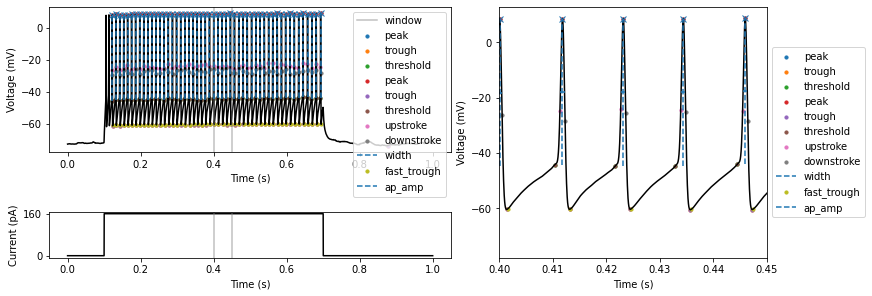

In [6]:
# These objects can already be used to calculate features on the single spike level
# (e.g. spike amplitude, spike width, etc.) by calling the `process_spikes` spikes
# method. which is mostly standard AllenSDK functionality.
example_sweep.process_spikes()

# The resulting spike features are stored in the `_spikes_df` attribute of the sweep
# and can be quickly plotted using the `plot_spike_features` from `EphysPy.plot`
plot_spike_features(example_sweep)
plt.show()

num_ap = 51.000 /.'
time to compute num_ap: 0.0210 s
time to lookup num_ap: 0.0000 s
51
{'peak_i': array([ 3054,  3303,  3572,  3844,  4108,  4380,  4656,  4938,  5215,
        5494,  5768,  6046,  6329,  6606,  6897,  7181,  7458,  7743,
        8030,  8316,  8600,  8874,  9147,  9429,  9716, 10003, 10296,
       10580, 10860, 11149, 11427, 11720, 12012, 12303, 12597, 12892,
       13182, 13471, 13764, 14047, 14354, 14644, 14928, 15229, 15526,
       15822, 16125, 16430, 16723, 17024, 17324]), 'peak_t': array([0.12216, 0.13212, 0.14288, 0.15376, 0.16432, 0.1752 , 0.18624,
       0.19752, 0.2086 , 0.21976, 0.23072, 0.24184, 0.25316, 0.26424,
       0.27588, 0.28724, 0.29832, 0.30972, 0.3212 , 0.33264, 0.344  ,
       0.35496, 0.36588, 0.37716, 0.38864, 0.40012, 0.41184, 0.4232 ,
       0.4344 , 0.44596, 0.45708, 0.4688 , 0.48048, 0.49212, 0.50388,
       0.51568, 0.52728, 0.53884, 0.55056, 0.56188, 0.57416, 0.58576,
       0.59712, 0.60916, 0.62104, 0.63288, 0.645  , 0.6572 , 0.66892,


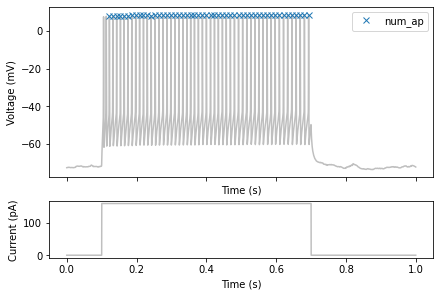

In [7]:
# Every feature that can be computed in `EphysPy` (apart from spike level features for now)
# is defined as a self-contained class, which inherit from `SweepFeature` and `SweepSetFeature`.
# and they can be found in the `ephyspy.features.base` module.

# This allows to handle features very flexibly and intuitively, by simply
# instantiating a feature object, e.g.:
num_ap = Num_AP(example_sweep)
print(num_ap)
# if not otherwise specified the feature is computed automatically at initialization
# however, this can be disabled as well if you just want to instantiate it for later use.
# If the feature has already been computed, it will not be recomputed unless explicitly
# requested and the cached value will be returned instead. This speeds up computation
# if the feature is reused during computation of other features.

timeit(lambda: num_ap.get_value(recompute=True), "time to compute num_ap")()
timeit(num_ap.get_value, "time to lookup num_ap")()

# Every feature is defined via its `_compute` method, that returns a feature's value
# and which can make use of everyhting that is available in the sweep object, i.e.
# the time, voltage and current arrays, as well as the metadata or even other features.
# This allows to easily define new features or modify existing ones, just by changing
# the `_compute` method. Furthermore, other features can be looked up during computation
# in a recursive manner, i.e. if a feature depends on another feature, the latter will
# be computed automatically if it is not already available. This enables every feature
# to be computed on its own and at any time, without having to worry about the order
# of computation.

# A feature's value can be accessed via its `value` attribute
print(num_ap.value)

# along with its value intermediate results of a feature's computation can also be
# stored and accsed via the `diagnostics` attribute.
print(num_ap.diagnostics)

# This helps with debugging and understanding how a feature is computed.
# This is further facilitated by the `plot` method, which can added to every
# feature and be used to visualize a feature's value and diagnostics.
num_ap.plot(show_sweep=True, show_stimulus=True)
plt.show()

# For additional information see the package's documentation

In [8]:
# This package already comes with a large number of features that can be used
# out of the box. These can be found in the `ephyspy.features` module.

# and can be listed as follows:

print("Available spike features:", list(available_spike_features().keys()))
print("Available sweep features:", list(available_sweep_features().keys()))
print("Available sweepset features:", list(available_sweepset_features().keys()))

# and computed via `get_feature`:
print("Num_AP:", get_feature("num_ap", example_sweep))

Available spike features: ['ap_peak', 'ap_width', 'ap_trough', 'ap_thresh', 'ap_amp', 'ap_udr', 'ap_ahp', 'ap_adp', 'isi']
Available sweep features: ['stim_amp', 'stim_onset', 'stim_end', 'num_ap', 'ap_freq', 'ap_latency', 'v_baseline', 'v_deflect', 'tau', 'ap_freq_adapt', 'ap_amp_slope', 'isi_ff', 'isi_cv', 'ap_ff', 'ap_cv', 'isi_adapt', 'isi_adapt_avg', 'ap_amp_adapt', 'ap_amp_adapt_avg', 'r_input', 'sag', 'v_sag', 'v_steady', 'sag_ratio', 'sag_fraction', 'sag_area', 'sag_time', 'v_plateau', 'rebound', 'rebound_aps', 'rebound_area', 'rebound_latency', 'rebound_avg', 'v_rest', 'num_bursts', 'burstiness', 'wildness', 'ap_adp', 'ap_ahp', 'ap_thresh', 'ap_amp', 'ap_width', 'ap_peak', 'ap_trough', 'ap_udr']
Available sweepset features: ['tau', 'v_rest', 'v_baseline', 'sag', 'sag_ratio', 'sag_fraction', 'sag_area', 'sag_time', 'rebound', 'rebound_aps', 'rebound_area', 'rebound_latency', 'rebound_avg', 'num_ap', 'ap_freq', 'wildness', 'ap_freq_adapt', 'ap_amp_slope', 'isi_ff', 'isi_cv', 'ap

In [9]:
# A different and perhaps more convenient way to interface with features is via
# the `add_features` method of `EphysSweep` and `EphysSweepSet`, which allows to
# add multiple features at once, either by name or by passing a list of feature objects.

# features can be added via the `add_features` method
example_sweep.add_features(available_spike_features())
example_sweep.add_features(available_sweep_features())

# and are stored in the `features` attribute
print("Spike features:", example_sweep.features)

# so far the features we just added, but have not been computed yet, we can do this
# either individually or all at once

# any single feature can be accessed by just calling its value
# if the feature has not been computed yet, it will be computed
print("Number of spikes:", example_sweep.features["num_ap"].value)

# computing all features at once can be done via the `get_features` method
example_sweep.get_features()

Spike features: {'num_ap': num_ap for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'stim_onset': stim_onset for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'stim_end': stim_end for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'stim_amp': stim_amp for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'ap_freq': ap_freq for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'ap_latency': ap_latency for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'v_baseline': v_baseline for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'v_deflect': v_deflect for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'tau': tau for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'ap_freq_adapt': ap_freq_adapt for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'ap_amp_slope': ap_amp_slope for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'isi_ff': isi_ff for <ephyspy.sweeps.EphysSweep object at 0x7f43f00284f0>, 'isi_cv': isi_cv for <e

{'num_ap': 51,
 'stim_onset': 0.10003999999999998,
 'stim_end': 0.7,
 'stim_amp': 160.0,
 'ap_freq': 85.00566704446965,
 'ap_latency': 0.020600000000000007,
 'v_baseline': -72.2112599178981,
 'v_deflect': nan,
 'tau': nan,
 'ap_freq_adapt': 1.04,
 'ap_amp_slope': 1.1214924560845603,
 'isi_ff': 1.673856502242144e-05,
 'isi_cv': 0.03828879509750462,
 'ap_ff': 0.0024860383588909637,
 'ap_cv': 0.006844992020558031,
 'isi_adapt': 1.080000000000001,
 'isi_adapt_avg': 1.0042413934986438,
 'ap_amp_adapt': 0.9899998672626559,
 'ap_amp_adapt_avg': 0.9997378572039421,
 'r_input': nan,
 'sag': nan,
 'v_sag': nan,
 'v_steady': nan,
 'sag_ratio': nan,
 'sag_fraction': nan,
 'sag_area': nan,
 'sag_time': nan,
 'v_plateau': nan,
 'rebound': nan,
 'rebound_aps': nan,
 'rebound_area': nan,
 'rebound_latency': nan,
 'rebound_avg': nan,
 'v_rest': nan,
 'num_bursts': nan,
 'burstiness': nan,
 'wildness': nan,
 'ap_adp': nan,
 'ap_ahp': -15.840062915082093,
 'ap_thresh': -44.65091896919443,
 'ap_amp': 53.0

In [10]:
# This workflow does also apply to sweepsets as it does to sweeps.
# again features can be added via the `add_features` method
example_sweepset.add_features(available_spike_features())
example_sweepset.add_features(available_sweepset_features())

# and are stored in the `features` attribute
print("Spike features:", example_sweepset.features)

# again any single feature can be accessed by just calling its value
print("Number of spikes:", example_sweepset.features["num_ap"].value)

# computing all features at once can be done via the `get_features` method
example_sweepset.get_features()

Spike features: {'tau': tau for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'v_rest': v_rest for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'v_baseline': v_baseline for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'sag': sag for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'sag_ratio': sag_ratio for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'sag_fraction': sag_fraction for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'sag_area': sag_area for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'sag_time': sag_time for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'rebound': rebound for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'rebound_aps': rebound_aps for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'rebound_area': rebound_area for <ephyspy.sweeps.EphysSweepSet object at 0x7f43f35660d0>, 'rebound_latency': rebound_latency for <ephyspy.sweeps.EphysSweepSet object at 

{'tau': 10.179987035403416,
 'v_rest': -62.06541878415433,
 'v_baseline': -66.29695482954716,
 'sag': -24.903075223513255,
 'sag_ratio': 1.146915530661233,
 'sag_fraction': 0.12809620825042944,
 'sag_area': 0.40018286287697513,
 'sag_time': 0.58392,
 'rebound': 4.217762775171707,
 'rebound_aps': nan,
 'rebound_area': 0.6927822162866062,
 'rebound_latency': 0.020320000000000005,
 'rebound_avg': 2.4772894251494932,
 'num_ap': 74.0,
 'ap_freq': 123.34155610374026,
 'wildness': 3.0,
 'ap_freq_adapt': 0.574468085106383,
 'ap_amp_slope': -2.4895841168458888,
 'isi_ff': 0.003676540109993611,
 'isi_cv': 0.6741612384142464,
 'ap_ff': 0.32659983605214654,
 'ap_cv': 0.07510665715037755,
 'isi': 0.006699999999999998,
 'burstiness': nan,
 'num_bursts': nan,
 'isi_adapt': 1.1259351620947635,
 'isi_adapt_avg': 1.0102931375472568,
 'ap_amp_adapt': 0.9642582876344018,
 'ap_amp_adapt_avg': 0.9991480297101588,
 'ap_ahp': -8.75121898541596,
 'ap_adp': 1.07387283095197,
 'ap_thresh': -39.27420811097878,
 '

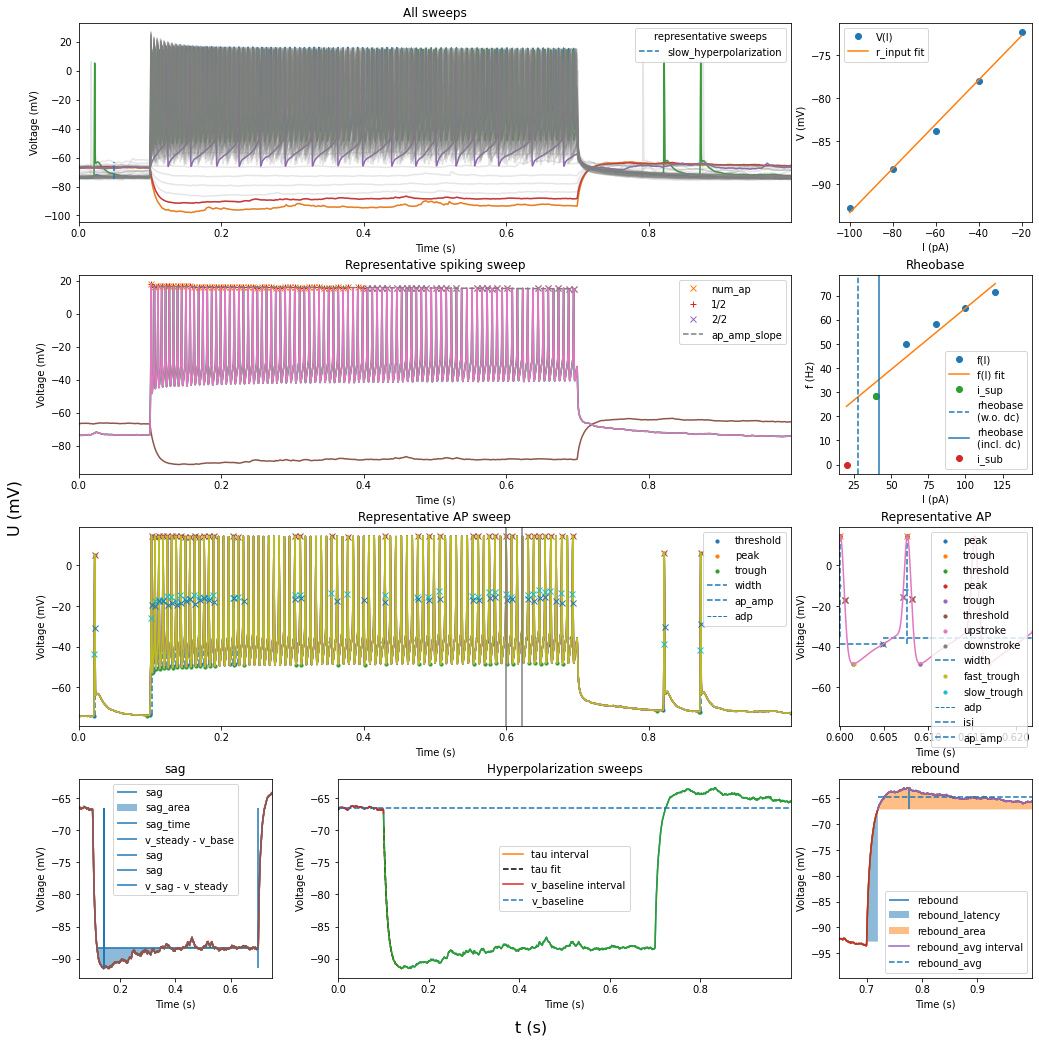

In [11]:
# Along with the abilty to compute and plot every feature on the individual level
# `EphysPy` also provides several higher level plotting functions that can be used
# to derive insights from the data.

# For example, `plot_sweepset_diagnostics` can be used to better trace how features
# were computed across a sweepset.

plot_sweepset_diagnostics(example_sweepset)
plt.show()

In [12]:
# To add custom features to the `EphysPy` ecosystem, they can be registered via
# the `register_custom_feature` function, which takes a feature class as input
# and stores it in a dictionary in the `ephyspy.features` module. This allows
# to access the feature via its name and to use it in the same way as any other
# feature, i.e. make use of recursive computation, caching, etc.

# Features should inherit from `SweepFeature` and/or `EphysSweepFeature` (in the case
# of spike features they can just be a function that expects a `EphysSweep` object).

# For more info see the package's documentation
print(register_custom_feature.__doc__, "\n")
print(SweepFeature.__doc__)

Add a custom feature class that inherits from `SweepFeature`
    or from `SweepSetFeature`. This makes the feature available to all the
    the EphysPy functionalities such as recursive computation of all dependend
    features that are called with `lookup_X_feature`, where X can be spike,
    sweep or sweepset.

    Args:
        Feature: Feature class to be added to EphysPy ecosystem. Feature
            must inherit from either `SweepFeature` or `SweesetFeature`.
     

Base class for all sweep level electrophysiological features.

    This class defines the interface for all electrophysiological features.
    All features should inherit from this class, and must implement the
    `_compute` method. The `_compute` method should return the feature value
    and optionally save diagnostic information for later debugging to
    `self._diagnostics`.

    The description of the feature should contain a short description of the
    feature, and a list of dependencies. The dependencies sho